In [45]:
# Libraries
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib import pyplot as plt
from pytorchtools import EarlyStopping

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Preprocessing and Separation Data

In [46]:
batch_size = 64
classes = ["Black Sea Sprat", "Gilt Head Bream", "Horse Mackerel", "Red Mullet", "Red Sea Bream", "Sea Bass", "Shrimp", "Striped Red Mullet", "Trout"]

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = '/content/drive/MyDrive/rybicky/NA_Fish_Dataset'

dataset = ImageFolder(root=data_dir, transform=train_transform)

split = (0.4, 0.3, 0.3)
train_size = int(split[0] * len(dataset))
valid_size = int(split[1] * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, (train_size, valid_size, test_size))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
valid_loader.dataset.transform = test_transform
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader.dataset.transform = test_transform

## Show random fish images from train data

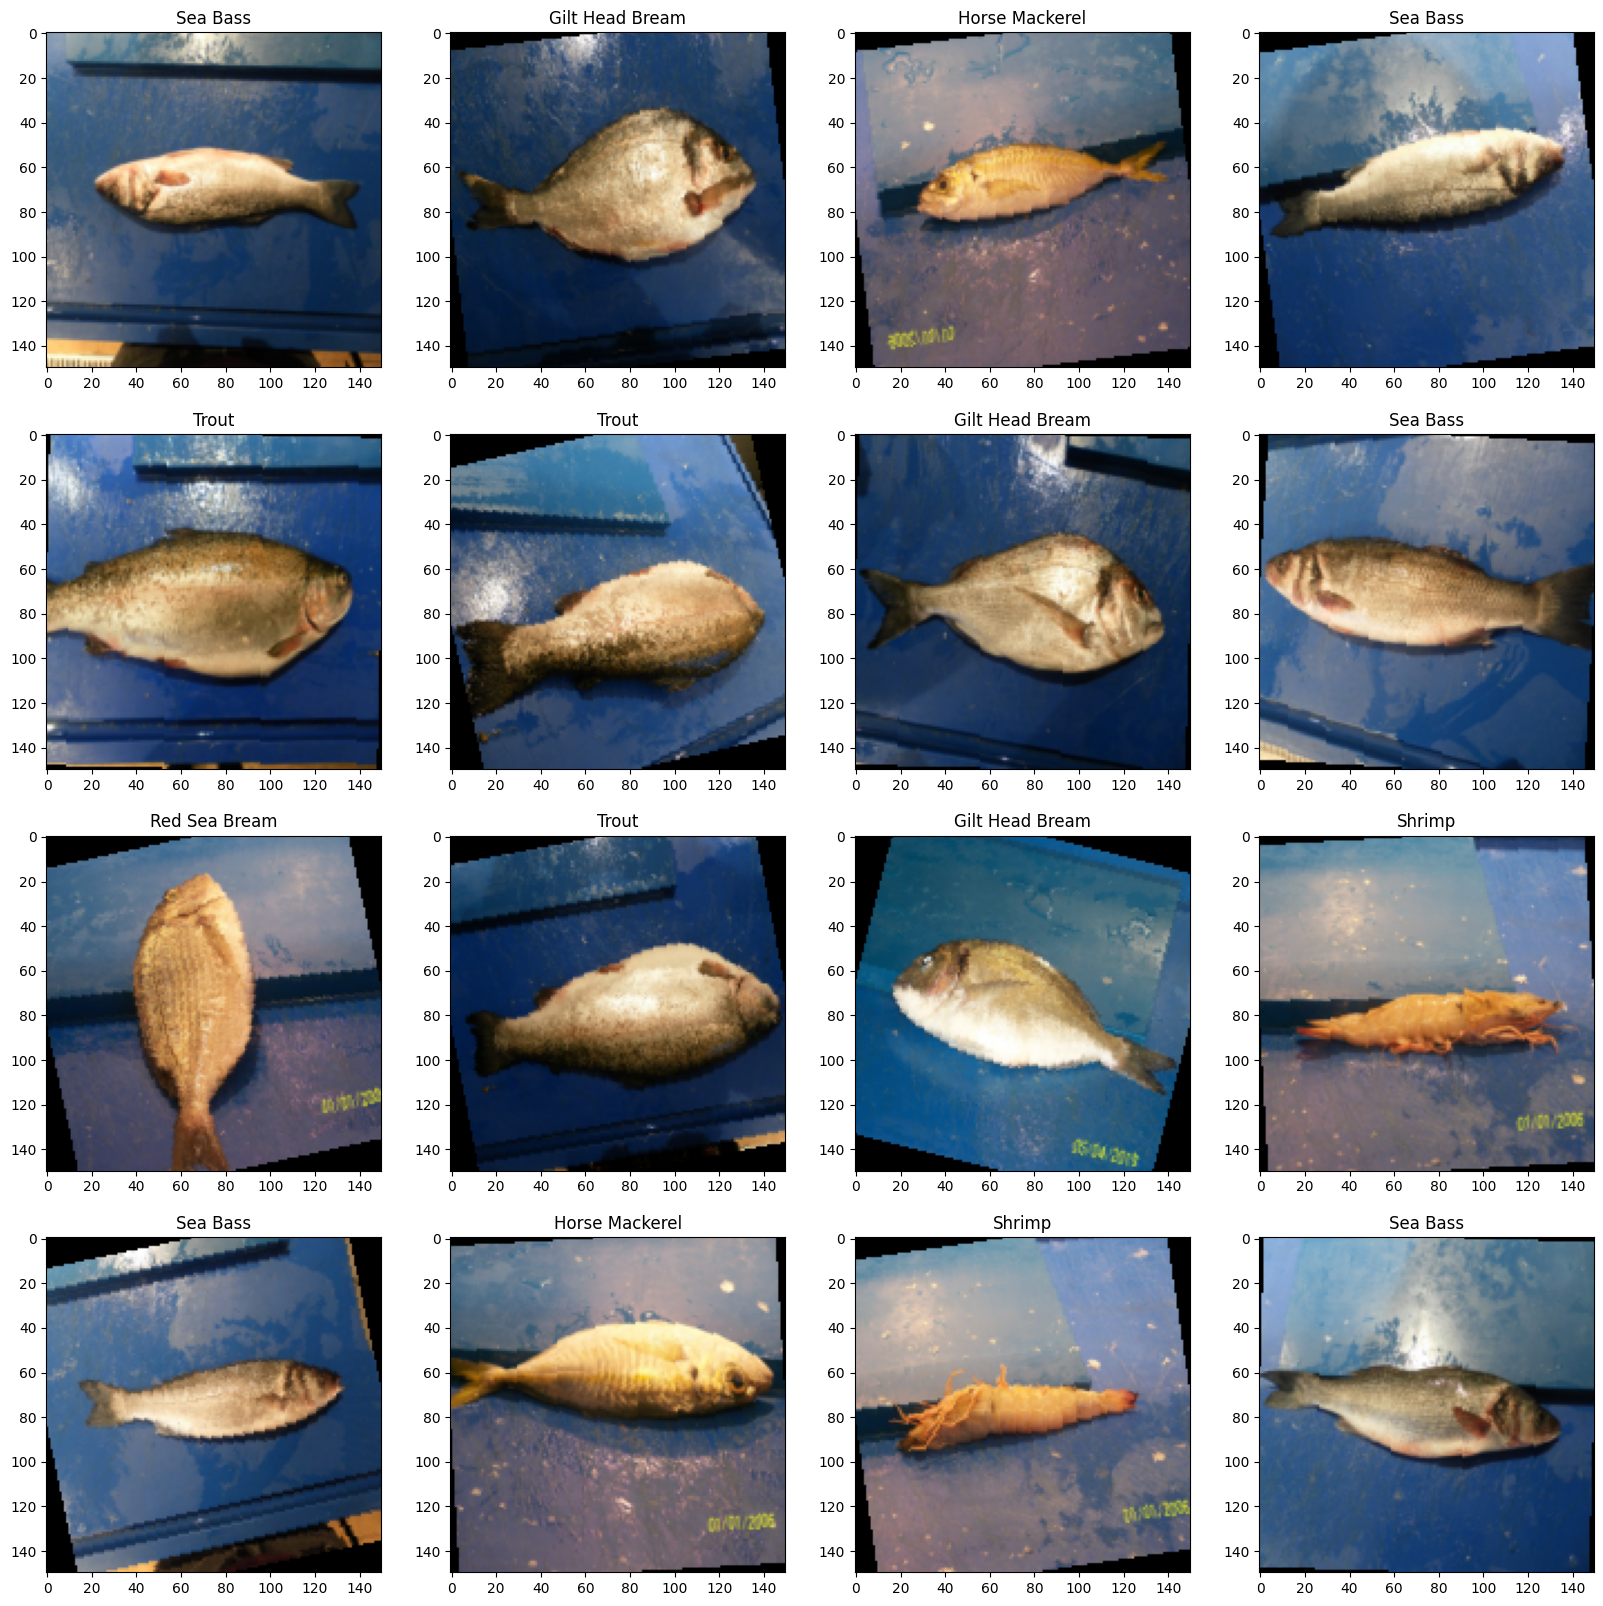

In [47]:
from torchvision.utils import make_grid

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
sample = np.random.randint(0, len(train_loader.dataset), 16)
for i, index in enumerate(sample):
    img, target = train_loader.dataset[index]
    img = img.permute(1, 2, 0)
    img = img.numpy() / 2 + 0.5

    axs[i // 4, i % 4].imshow(img)
    axs[i // 4, i % 4].set_title("{}".format(classes[target]))

## Model architecture

In [49]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, num_classes):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
    self.batch_norm_conv1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 64, 3)
    self.batch_norm_conv2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.batch_norm_conv3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 128, 3)
    self.batch_norm_conv4 = nn.BatchNorm2d(128)

    self.fc1 = nn.Linear(128 * 7 * 7, 256)
    self.batch_norm1 = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 128)
    self.batch_norm2 = nn.BatchNorm1d(128)
    self.fc3 = nn.Linear(128, 64)
    self.batch_norm3 = nn.BatchNorm1d(64)
    self.fc4 = nn.Linear(64, num_classes)

    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(p=0.2, inplace=False)  # random 20% nn will disconnect

  def forward(self, x):
      x = self.pool(self.batch_norm_conv1(F.relu(self.conv1(x))))
      x = self.pool(self.batch_norm_conv2(F.relu(self.conv2(x))))
      x = self.pool(self.batch_norm_conv3(F.relu(self.conv3(x))))
      x = self.pool(self.batch_norm_conv4(F.relu(self.conv4(x))))
      x = self.dropout(x)
      x = x.view(-1, 128 * 7 * 7)

      x = self.batch_norm1(F.relu(self.fc1(x)))
      x = self.dropout(x)
      x = self.batch_norm2(F.relu(self.fc2(x)))
      x = self.dropout(x)
      x = self.batch_norm3(F.relu(self.fc3(x)))
      x = self.dropout(x)
      x = self.fc4(x)

      return x

## Train and Testing Validation Data

In [50]:
def train(model, n_epochs, train_loader, valid_loader, criterion, optimizer, scheduler=None, early_stop_count=0):
  avg_train_losses = []
  avg_valid_losses = []
  avg_valid_acc = []
  batch_train_losses = []

  # make regularization  if accuracy will be decrease
  early_stopping = EarlyStopping(patience=early_stop_count, verbose=True, path="net.pth")

  for epoch in range(1, n_epochs + 1):
    train_losses, valid_losses, valid_accs = [], [], []

    # Training
    model.train()
    for input_data, classes in train_loader:
      data = input_data.to(device)
      target = classes.long().to(device)

      optimizer.zero_grad()
      output = model(data)  # predicted
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())

    # Evaluating validation data
    model.eval()
    for input_data, classes in valid_loader:
      data = input_data.to(device)
      target = classes.long().to(device)

      output = model(data)
      loss = criterion(output, target)
      valid_losses.append(loss.item())

      _, pred = torch.max(output, 1)

      valid_accs.append(np.sum(target.cpu().numpy() == pred.cpu().numpy()) / pred.shape[0])

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    valid_acc = np.average(valid_accs)

    if scheduler:
      scheduler.step()

    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    avg_valid_acc.append(valid_acc)
    batch_train_losses.extend(train_losses)

    epoch_len = len(str(n_epochs))
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                f'train_loss: {train_loss:.5f} ' +
                f'valid_loss: {valid_loss:.5f} ' +
                f'valid_acc: {valid_acc*100:2.2f} %')

    if scheduler:
      print_msg = print_msg + " lr: {:.5f}".format(scheduler.get_last_lr()[0])
    print(print_msg)

    if early_stop_count:
      early_stopping(valid_loss, model)

      if early_stopping.early_stop:
        print("Early stopping")
        break

  if early_stop_count:
    model.load_state_dict(torch.load("net.pth"))

  return avg_valid_losses, avg_train_losses, model, batch_train_losses

## Vizualization and Testing data

In [51]:
def visualize_batch_loss(batch_train_losses):
  plt.figure(figsize=(15, 3))
  xx = np.arange(0, len(batch_train_losses), 1)
  y_train = np.array(batch_train_losses)
  plt.plot(xx, y_train)
  plt.legend(["Training Loss"], labelcolor="black")
  plt.xlabel("Batches")
  plt.ylabel("Loss")
  plt.title("Loss of validation and training set")
  plt.show()

def visualize_loss(avg_valid_losses, avg_train_losses):
  plt.figure()
  xx = np.arange(0, len(avg_valid_losses), 1)
  y_valid = np.array(avg_valid_losses)
  y_train = np.array(avg_train_losses)
  plt.plot(xx, y_valid)
  plt.plot(xx, y_train, color='red')
  plt.legend(("Validation Loss", "Training Loss"), labelcolor="black")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss of validation and training set")

  plt.show()

def print_accuracy(model, criterion, test_loader):
  model.eval()
  y_gts = np.array([])
  y_preds = np.array([])

  for images, labels in test_loader:
      outputs = model(images)
      _, pred = torch.max(outputs, 1)

      y_gts = np.hstack((y_gts, labels.cpu().numpy()))
      y_preds = np.hstack((y_preds, pred.cpu().numpy()))

  accuracy = np.sum(y_gts == y_preds) / y_preds.shape[0] * 100
  print("Accuracy the NN is: {:2.2f} %".format(accuracy))

# Settings and Experiments

[ 1/20] train_loss: 3.14527 valid_loss: 50238.36458 valid_acc: 9.38 % lr: 0.10000
Validation loss decreased (inf --> 50238.364583).  Saving model ...
[ 2/20] train_loss: 2.45106 valid_loss: 5578.14990 valid_acc: 9.38 % lr: 0.10000
Validation loss decreased (50238.364583 --> 5578.149902).  Saving model ...
[ 3/20] train_loss: 2.05214 valid_loss: 936.65796 valid_acc: 6.25 % lr: 0.10000
Validation loss decreased (5578.149902 --> 936.657959).  Saving model ...
[ 4/20] train_loss: 1.48150 valid_loss: 398.68669 valid_acc: 6.25 % lr: 0.10000
Validation loss decreased (936.657959 --> 398.686686).  Saving model ...
[ 5/20] train_loss: 1.37556 valid_loss: 151.18608 valid_acc: 6.25 % lr: 0.02500
Validation loss decreased (398.686686 --> 151.186081).  Saving model ...
[ 6/20] train_loss: 1.17321 valid_loss: 40.14189 valid_acc: 7.29 % lr: 0.02500
Validation loss decreased (151.186081 --> 40.141893).  Saving model ...
[ 7/20] train_loss: 1.09149 valid_loss: 15.53238 valid_acc: 11.46 % lr: 0.02500
Va

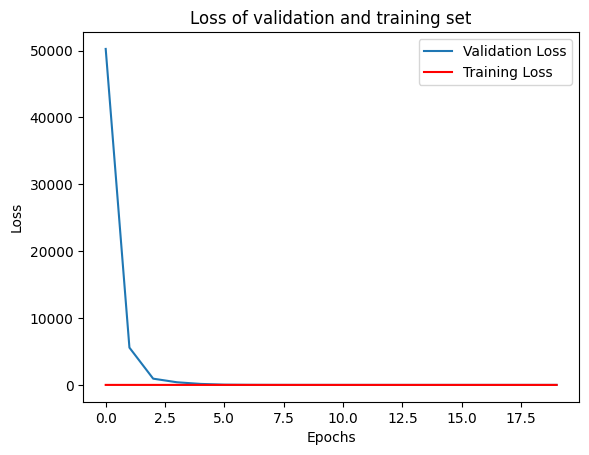

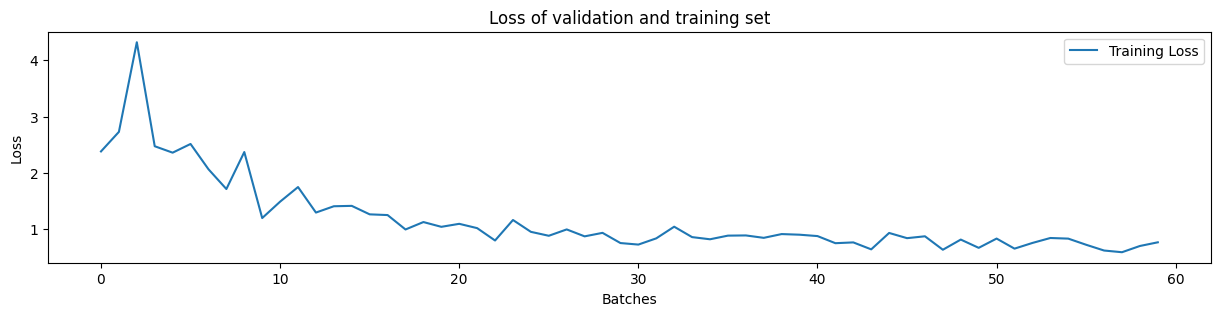

Accuracy the NN is: 63.57 %


In [52]:
import torch.optim as optim

model = Net(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
n_epochs = 20

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [5, 10, 15, 18], 0.25)
avg_valid_losses, avg_train_losses, model, batch_train_losses = train(model, n_epochs,
                                                                      train_loader, valid_loader,
                                                                      criterion=criterion,
                                                                      optimizer=optimizer,
                                                                      scheduler=scheduler,
                                                                      early_stop_count=10)

visualize_loss(avg_valid_losses, avg_train_losses)
visualize_batch_loss(batch_train_losses)

print_accuracy(model, criterion, test_loader)